In [0]:
#make imports 

import cv2
import sys
import math 
import numpy as np
import skimage
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage as nd

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from skimage.util import img_as_float
#from skimage.filters import gabor_kern
from skimage.filters import prewitt_h,prewitt_v
from skimage.io import imshow

from sklearn.preprocessing import normalize
from scipy.linalg import fractional_matrix_power
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial import distance

from scipy.spatial.distance import pdist
import math
from itertools import combinations
%matplotlib inline

In [0]:
def scalableCosine(X,k,type='NJW'):
  '''
  X: is the set of datapoints (which could be L2 normalized or not) 
  k: the number of classes 
  type: the kind of spectral clustering to use
  '''
  #normalize the rows in the data 
  X = normalize(X, norm='l2', axis=1)
  #get the shape of the data (both row and height)
  row=X.shape[0]
  col=X.shape[0]
  #get some matrices needed
  IdentityX=np.identity(row)
  onesX=np.ones((row,row))
  W1 = np.zeros((row, row))
  #compute X transpose X
  XX=np.dot(X,X.T)
  #check if every value in XX are between 0 and 1
  neg=np.any(XX < 0)
  if neg==True:
    XX = np.true_divide((XX+onesX),2)

  W = XX - IdentityX
  W1=W.dot(onesX) 
  D=W1.diagonal()
  D1= np.diag(D)
  
  X_bar=fractional_matrix_power(D1, -0.5).dot(X)
  U, s, V = np.linalg.svd(X_bar)
  UP = U[:,:k].copy()
  
  if type=='NCUT':
    UP = fractional_matrix_power(D1, -0.5).dot(UP)
  elif type=='DM':
    UP = fractional_matrix_power(D1, -0.5).dot(UP).dot(s)
    
  
  UPnorm = normalize(UP, norm='l2')
  
  kmeans = KMeans(n_clusters=2)
  kmeans.fit(UPnorm)
  y_kmeans = kmeans.predict(UPnorm)
  
  return y_kmeans

def dist(p1, p2):
  '''
  p1: is a point (with n - dimensions)
  p2: is a point (with n - dimensions)

  returns the euclidean distance
  '''
  '''(x1, y1), (x2, y2) = p1, p2
  math.sqrt((x2 - x1)**2 + (y2 - y1)**2)'''
  return    distance.euclidean(p1, p2)

def gausker(x1,x2,sigma=1):
  '''
  x1: is a point (with n - dimensions)
  x2: is a point (with n - dimensions)

  returns the gaussian distance
  '''
  dist = np.linalg.norm(x1-x2)
  return np.exp(-dist**2/(2.*(sigma**2.)))

def truncate_top_k(x, k, inplace=False):
    m, n = x.shape
    # get (unsorted) indices of top-k values
    topk_indices = np.argpartition(x, -k, axis=1)[:, -k:]
    # get k-th value
    rows, _ = np.indices((m, k))
    kth_vals = x[rows, topk_indices].min(axis=1)
    # get boolean mask of values smaller than k-th
    is_smaller_than_kth = x < kth_vals[:, None]
    # replace mask by 0
    if not inplace:
        return np.where(is_smaller_than_kth, 0, x)
    x[is_smaller_than_kth] = 0
    return x  

In [0]:
def scalableGaussian(X,k,l,s,sig=None,type='NJW'):
  #generate l landmark points from the data - in this case cluster centers
  kmeans_model = KMeans(n_clusters=l)
  kmeans_model.fit(X)
  #get the cluster centers from the Kmean model
  features2 = np.array(kmeans_model.cluster_centers_)
  #initialize feature array 
  row=X.shape[0]
  #create a new feature matrix for the data initialize as a 0 matrix (which is likely to be sparse )
  A=np.zeros((row,l), dtype=float)
  
  #fill the feature matrix A up

  #get the m-nearest neigbor for each row and for each of the rest set distance to 0
  for i in range(0,row):
    for j in range(0,l):
      #compute average distance
      points = list(zip(X[i],features2[j]))
      distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
      avg_distance = sum(distances) / len(distances)
      sigma=avg_distance/2
      if sig==None:
        #average distance ends here
        dis = gausker(X_mn[i],features2[j],sigma=sigma) 
      else:
        dis = gausker(X_mn[i],features2[j],sigma=0.5) 

      A[i][j]=dis      
  A=truncate_top_k(A,s)
  y_label=scalableCosine(A,k)
  
  return y_label
  

In [0]:
#create a function for plotting 
def plotData(x, y,c=None, xlabel="X",ylabel="Y",title="Plot",dot_size=20,cmap='viridis'):
  plt.scatter(x,y,c=c,s=dot_size, cmap=cmap)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title, fontsize=18, fontweight='demi')

**Create Synthetic data and test the spectral clustering algorithm on them**

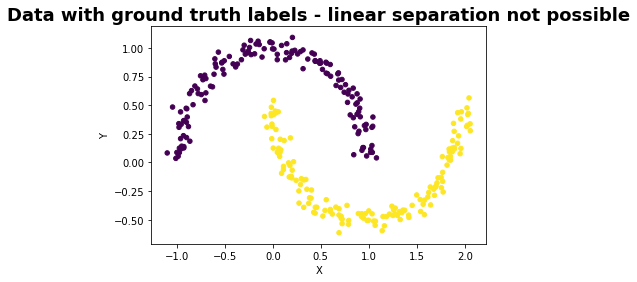

In [5]:
from sklearn.datasets import make_moons
X_mn, y_mn = make_moons(300, noise=.05, random_state=21)
plotData(X_mn[:, 0], X_mn[:, 1],c=y_mn,title='Data with ground truth labels - linear separation not possible')

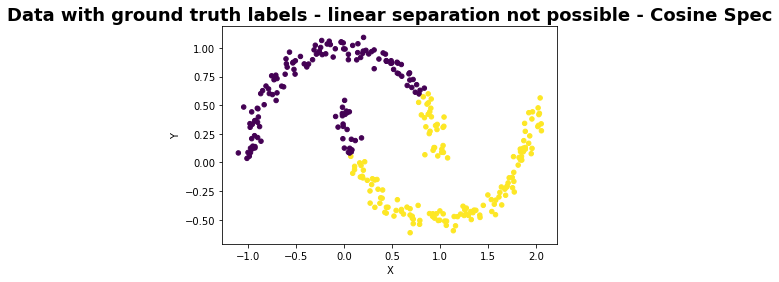

In [6]:
classLabels = scalableCosine(X_mn,k=2,type='NJW')
plotData(X_mn[:, 0], X_mn[:, 1],c=classLabels,title='Data with ground truth labels - linear separation not possible - Cosine Spec')

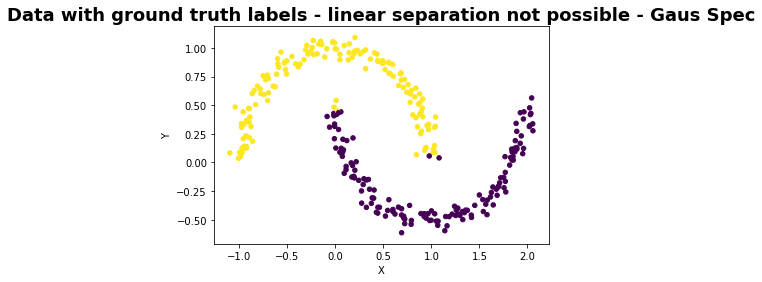

In [25]:
classLabels = scalableGaussian(X_mn,k=2,l=12,s=2,sig=0.5,type='NJW')
plotData(X_mn[:, 0], X_mn[:, 1],c=classLabels,title='Data with ground truth labels - linear separation not possible - Gaus Spec')

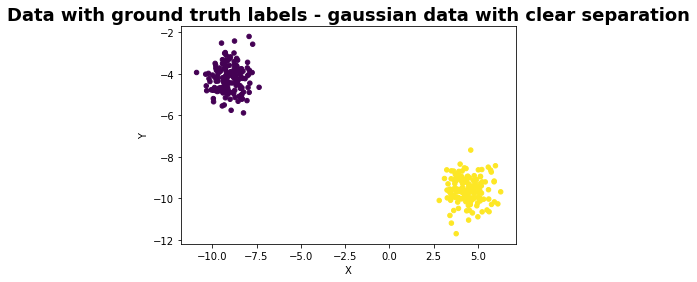

In [8]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=2,cluster_std = 0.65, n_features=2,shuffle = True,random_state=21)
plotData(X[:, 0], X[:, 1],c=y,title='Data with ground truth labels - gaussian data with clear separation')

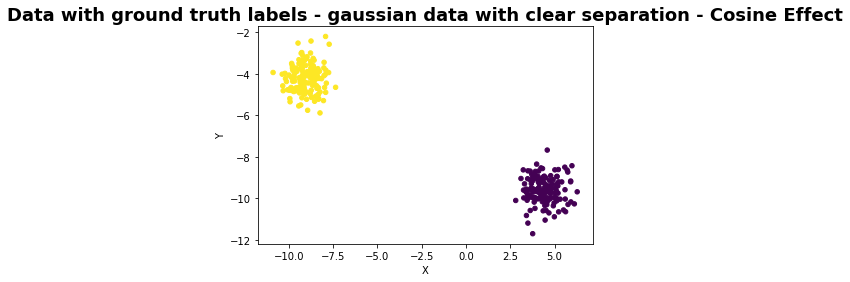

In [9]:
classLabels = scalableCosine(X,k=2,type='NJW')
classLabels
plotData(X[:, 0], X[:, 1],c=classLabels,title='Data with ground truth labels - gaussian data with clear separation - Cosine Effect')

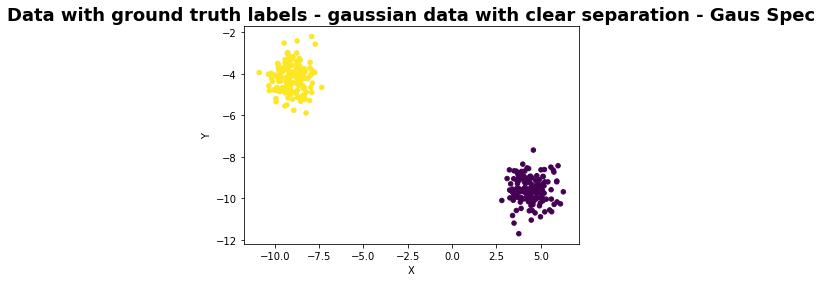

In [10]:
classLabels = scalableGaussian(X,k=2,l=8,s=5, type='NJW')
plotData(X[:, 0], X[:, 1],c=classLabels,title='Data with ground truth labels - gaussian data with clear separation - Gaus Spec')

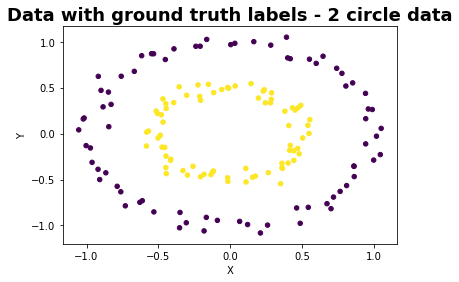

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=150,noise=0.05, factor=0.5, random_state=21)
plotData(X[:, 0], X[:, 1],c=y,title='Data with ground truth labels - 2 circle data')

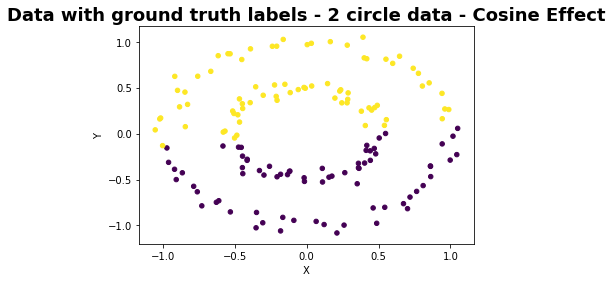

In [12]:
classLabels = scalableCosine(X,k=2,type='NJW')
classLabels
plotData(X[:, 0], X[:, 1],c=classLabels,title='Data with ground truth labels - 2 circle data - Cosine Effect')

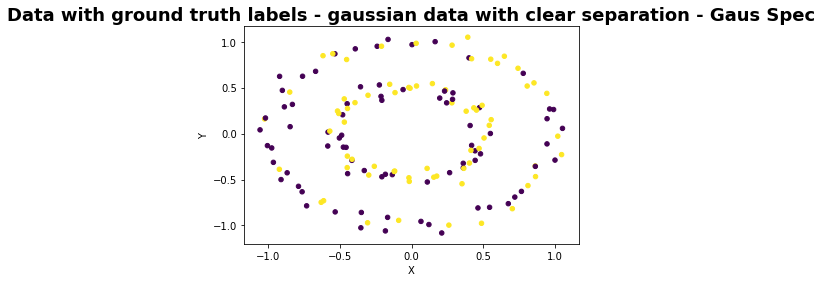

In [13]:
classLabels = scalableGaussian(X,k=2,l=15,s=7,type='NJW')
plotData(X[:, 0], X[:, 1],c=classLabels,title='Data with ground truth labels - gaussian data with clear separation - Gaus Spec')

**Image Segmentation** - Feature Extraction and Segmentation